<a href="https://colab.research.google.com/github/marcoseadr/Processamento_de_linguagem_natural/blob/main/Processamento_de_linguagem_natural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install unidecode
!pip install fractions
!pip install googletrans
!pip install ibm_watson
!pip install ibm_cloud_sdk_core
!pip install dotenv
# Load EDA Pkgs
import pandas as pd
import numpy as np
import random

# Load ML Pkgs
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('rslp')
stop = stopwords.words('portuguese')
from textblob import TextBlob
stemmer = nltk.stem.RSLPStemmer()

#charts & others stuff
!pip install unidecode
from unidecode import unidecode
import matplotlib.pyplot as plt
import re
import string
from fractions import Fraction
import json
import os
!pip install googletrans
from googletrans import Translator
translator = Translator()

from ibm_watson import NaturalLanguageUnderstandingV1
from ibm_watson import LanguageTranslatorV3
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
from ibm_watson.natural_language_understanding_v1  import Features, CategoriesOptions, SentimentOptions



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 13.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement fractions (from versions: none)
ERROR: No matching distribution found for fractions
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 3.6 MB/s 
     |████████████████████████████████| 1.3 MB 30.9 MB/s 
     |████████████████████████████████| 42 kB 1.6 MB/s 
     |████████████████████████████████| 53 kB 2.6 MB/s 
     |████████████████████████████████| 65 kB 4.1 MB/s 
  Created wheel for googletrans: filename=googletrans-3.0.0-py3-none-any.whl size=15735 sha256=4719fcc77ad26588e2a2e12f80c990c2d6f85a5e25516c39dafd0e878af34ef3
  Stored in directory: /root/.cache/pip/wheels/20/da/eb/

## Base de dados contendo todas as colunas do Alexandre Garcia

In [4]:
cag = pd.read_json(f"https://raw.githubusercontent.com/lucianomcsilva/articulistas/main/alexandre_garcia.json")


## Amostra da base de dados

In [5]:
cag.sample(10)

,author,title,content
48,Alexandre Garcia,Alexandre Garcia : Conhecer a Amazônia,\nDias depois de terem estado na Embaixada da...
81,Alexandre Garcia,Alexandre Garcia: Cidadão tutelado,\nO artigo 144 da Constituição estabelece que...
66,Alexandre Garcia,Noiva da Cultura,\nA Namoradinha do Brasil aceitou ser Secretá...
4,Alexandre Garcia,As bolhas,"\nNum debate com empresários cearenses, o \nm..."
40,Alexandre Garcia,Alexandre Garcia: Coincidências,"\nPrevino o leitor, como os filmes previnem: ..."
45,Alexandre Garcia,Alexandre Garcia: Milagre brasileiro,"\nNos anos 70, nosso País desfrutou do Milagr..."
79,Alexandre Garcia,Fundo ilegítimo,\nDeputados e senadores aprovaram a quase \nt...
47,Alexandre Garcia,Alexandre Garcia: Democracia e Factoide,"\nNo último dia 12, a procuradora Raquel Dodg..."
2,Alexandre Garcia,Explica ou confunde?,"\nDepois de quatro anos e meio preso, o ex-\n..."
37,Alexandre Garcia,Alexandre Garcia: O dinheiro do crime,\nImagine que você tenha tido a má sorte de s...


## Função para singularizar as palavras

In [6]:
"""
Thanks for https://simasware.wordpress.com/2014/02/28/pluralizacao-em-pt-br-rails/
"""

import re
import unicodedata
import string

INVARIAVEL = [  'lápis',
                'atlas',
                'pires',
                'ônibus',
                'vírus',
                'bônus',
                'ônus',
                'cais',
                'xis',
                'óculos',
                'ourives',
                'parabéns',
                'atras',

            ]

def singularizar(PalavraOriginal):
    """ Remove acentos e deixa tudo minuscula"""
    palavra = PalavraOriginal.lower()

    # for wd in INVARIAVEL:
    #     if transliterate(wd).lower() == palavra:
    #         return palavra

    """      Lista de regras, composto em tuplas de valor a ser buscado e regra de substituição    """
    rules = []

    """    Palavras terminadas em ns    """
    rules.append((r"^([a-zA-z]*)ns$", r"\1m"))

    """ Palavras terminas em r ou z luzes - luz, flores - flor, arrozes - arroz"""
    rules.append((r"^([a-zA-z]*)res$", r"\1r"))
    rules.append((r"^([a-zA-z]*)zes$", r"\1z"))
    rules.append((r"^([a-zA-z]*)ses$", r"\1s"))

    """    Palavras terminadas em ão    """
    rules.append((r"^([a-zA-z]*)oes$", r"\1ao"))
    rules.append((r"^([a-zA-z]*)aos$", r"\1ao"))
    rules.append((r"^([a-zA-z]*)aes$", r"\1ao"))

    """ Palavras regulares, casos simples: carros, arvores, aboboras"""
    rules.append((r"^([a-zA-z]*)(a|e|o|u)is$", r"\1\2l"))

    """ Palavras terminas em il  cantis - cantil """
    rules.append((r"^([a-zA-z]*)is$", r"\1il"))

    """ Palavras terminas em les  mal - males, mel - meles """
    rules.append((r"^([a-zA-z]*)les$", r"\1l"))


    """ Palavras regulares, casos simples: carros, arvores, aboboras"""
    rules.append((r"^([a-zA-z]*)(a|e|i|o|u)s$", r"\1\2"))
    
    for rule in rules:
        if re.match(rule[0], palavra) is not None:
            return re.sub(rule[0], rule[1], palavra, 1, re.IGNORECASE)
    return palavra

## Tratamento de todas as colunas

In [7]:
import nltk
from nltk.corpus import stopwords
from unidecode import unidecode
import string
nltk.download('stopwords')

stop = stopwords.words('portuguese')

#Transforma em minuscula e remoção de acentos 
#titles['title_treated'] = titles['title'].str.lower().apply(lambda x: unidecode(x))
cag['content_treated'] = cag['content'].apply(lambda x: unidecode(x))

# remocação de pontuaçao
cag['content_treated'] = cag['content_treated'].str.replace('[{}]'.format(string.punctuation), '')

# remocação de numeros
cag['content_treated'] = cag['content_treated'].str.replace('[{}]'.format(string.digits), '')

# remoção de palavras de parada
cag['content_treated'] = cag['content_treated'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in (stop)]))

# Removendo plural
cag['content_treated'] = cag['content_treated'].apply(lambda x: ' '.join([singularizar(word) for word in x.split()]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: The default value of regex will change from True to False in a future version.


## Amostragem

In [8]:
cag['content_treated']

0     imagem brasil exterior tao deteriorada pergunt...
1     dia trabalhador milhao brasileiro risco covid ...
2     quatro ano meio preso ex presidente camara edu...
3     ano jornalista cobriamo supremo adivinhavamo d...
4     debate empresario cearens ministro paulo guede...
                            ...                        
82    me abril entrou alerta perigo democracia brasi...
83    repente unico juiz decide estao anulado proces...
84    novo ministro saude vai longe esperanca despol...
85    presidente acaba dar arrumacao auxiliar busca ...
86    cada vez ouvido escrito termo crise institucio...
Name: content_treated, Length: 87, dtype: object

## Nuvem de palavras com as colunas tratadas

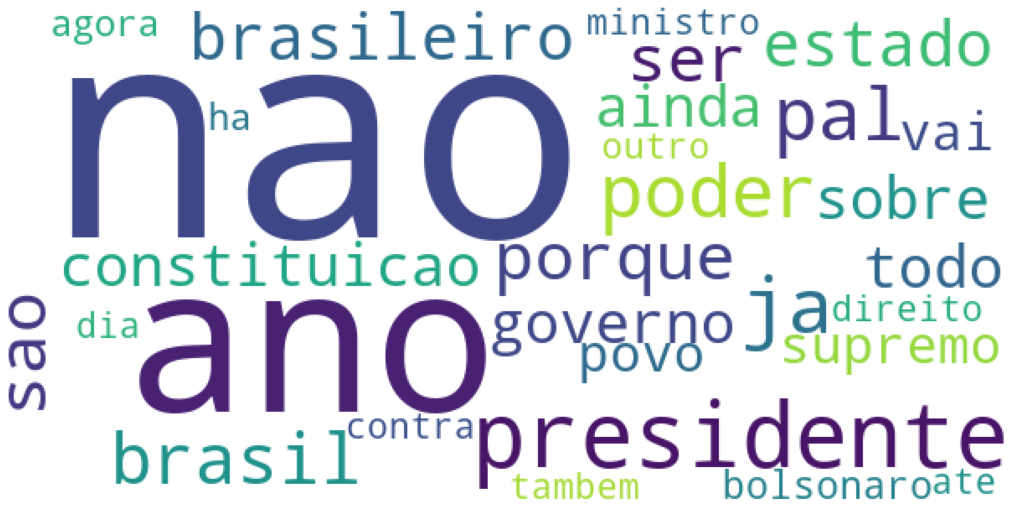

In [9]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

original_text = ' '.join(cag['content_treated'])

wordcloud2 = WordCloud(collocations=False, normalize_plurals=False, stopwords=None, width=600, height=300, background_color='white', max_words=30).generate(original_text)
# Generate plot
# plot the WordCloud image                        
plt.figure(figsize = (18, 18), facecolor = 'White') 
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

## Visualização em tabela

In [10]:
#cria uma lista com todos os tokens
from nltk.tokenize import word_tokenize
nltk.download('punkt')

big_line = ' '.join(sent for sent in cag['content_treated'])
tokens = word_tokenize(big_line)
fdist1 = nltk.FreqDist(tokens)
fdist1 = sorted(fdist1.items(), key=lambda x: x[1], reverse=True)
pd_freq = pd.DataFrame.from_dict(fdist1)
n = 0
pd_freq.iloc[n:n+20]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,0,1
0,nao,417
1,ano,157
2,presidente,148
3,ja,105
4,pal,97
5,poder,97
6,brasil,89
7,sao,85
8,porque,81
9,ser,80


## Remoção de palavras indesejadas

In [11]:
ignorewords = [ 'nao','pal','ja','sao','porque','ser','todo','sobre','ainda','vai','ha','agora','outro','tambem','ate','so','pode','vez','ter','apena','lel','assim']
cag['content_treated'] = cag['content_treated'].str.lower().apply(lambda x: ' '.join([word for word in x.split() if word not in (ignorewords)]))
cag['content_treated'] = cag['content_treated']

## Visualização em tabela

In [60]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')

big_line = ' '.join(sent for sent in cag['content_treated'])
tokens = word_tokenize(big_line)
fdist1 = nltk.FreqDist(tokens)
fdist1 = sorted(fdist1.items(), key=lambda x: x[1], reverse=True)
pd_freq = pd.DataFrame.from_dict(fdist1)
n = 0
teste2 = pd_freq.iloc[n:n+5]
teste2


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,0,1
0,ano,157
1,presidente,148
2,poder,97
3,brasil,89
4,brasileiro,74


## Nuvem de palavras

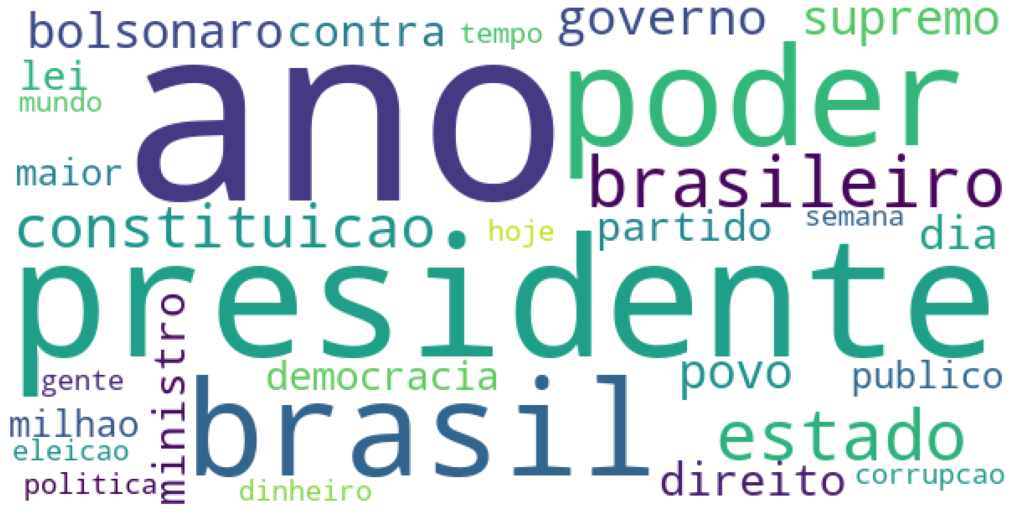

In [13]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

original_text = ' '.join(cag['content_treated'])

wordcloud2 = WordCloud(collocations=False, normalize_plurals=False, stopwords=None, width=600, height=300, background_color='white', max_words=30).generate(original_text)
# Generate plot
# plot the WordCloud image                        
plt.figure(figsize = (18, 18), facecolor = 'White') 
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

## Agora sabemos as principais palavras do colunista Alexandre Garcia e sabemos que ele escreve sobre política. Será que apenas com essas palavras coletadas é possível comparar com outros colunistas?


In [14]:
import pandas as pd
df = pd.read_json('https://raw.githubusercontent.com/lucianomcsilva/articulistas/main/classificacao.jl', lines=True)


## Base de dados de outros colunistas

In [15]:
df.sample(10)

,author,title,content
10622,Menon,Crespo precisa assumir imediatamente. Não pode...,\nEstá praticamente certo que Hernán Crespo s...
11567,Ricardo Feltrin,"Vinte dias após deixar SBT, Kallyna Sabino fec...",\nGraças a Deus ela mal sentiu o desemprego n...
2202,Mauricio Ricardo,Férias em Home Office,\nConfira! \n \n
20259,Milton Neves,Altitude da Bolívia mata o primeiro! Dona Fifa...,\nSempre falei e escrevi em todas as minhas t...
16032,Josias de Souza,"Militares rebatem Gilmar, mas estão incomodado...",\nO ministro Gilmar Mendes gosta de repetir u...
18224,Ricardo Feltrin,"10 estrelas que começaram a brilhar na TV em ""...",\nNão há dúvidas que “Malhação” é um sucesso....
18901,Ricardo Feltrin,"Além de perder TVs abertas, operadoras correm ...",\nA Agência Nacional de Telecomunicações (Ana...
5758,Menon,"Daniel Alves, boquirroto, é minúsculo diante d...","\nDaniel Alves, após \nconquistar a medalha o..."
2110,Menon,Portuguesa estreia com vitória fora de campo,"\nA Portuguesa estreia hoje, dia 27, na Série..."
273,Milton Neves,"O Atlético de Madrid de Simeone, melhor técnic...",\nManchester City 1 x 0 Atlético de Madrid\nN...


## Categorizando os colunistas

In [16]:
authors = {        
    'author': [
    "Mauro Cesár Oliveira",
    "Milton Neves",
    "Menon",
    "Danilo Lavieri",
    #''' Tecnologia '''
    "Alessandra Montini",
    "Andre Noel",
    "Guilherme Rambo",
    "Blog do Dunker",
    #'''Cultura pop'''
    "Chico Barney",
    "Roberto Sadovski",
    "Ricardo Feltrin",
    "Mauricio Ricardo",
    #''' Politica '''
    "Josias de Souza",
    "Kennedy Alencar",
    "Leonardo Sakamoto",
    "Thays Oyama"
    ],
    'category': [ "Esportes", "Esportes", "Esportes", "Esportes", 
                 "Tecnologia", "Tecnologia", "Tecnologia", "Tecnologia", 
                 "Cultura pop", "Cultura pop", "Cultura pop", "Cultura pop", 
                 "Politica", "Politica", "Politica", "Politica",                 
    ]
}       
df_authors = pd.DataFrame.from_dict(data=authors) 
df_authors

,author,category
0,Mauro Cesár Oliveira,Esportes
1,Milton Neves,Esportes
2,Menon,Esportes
3,Danilo Lavieri,Esportes
4,Alessandra Montini,Tecnologia
5,Andre Noel,Tecnologia
6,Guilherme Rambo,Tecnologia
7,Blog do Dunker,Tecnologia
8,Chico Barney,Cultura pop
9,Roberto Sadovski,Cultura pop


In [17]:
df_final = df.merge(df_authors)
df_final.sample(20)

,author,title,content,category
4809,Ricardo Feltrin,"""Para ter restaurante não basta ser famoso"", d...",\nCarlos Bertolazzi acha que 2018 está sendo ...,Cultura pop
13538,Leonardo Sakamoto,Temer diz que não vão com sua cara. Falta afet...,"\n""Às vezes, as pessoas não vão com a minha c...",Politica
13619,Leonardo Sakamoto,"Aliado de Temer reclamar de ""subversão da orde...","\nO deputado federal Carlos Marun (PMDB-MS), ...",Politica
17648,Mauricio Ricardo,O jeito mais barato de bombar no YouTube! (Fal...,\nConfira! \n \n,Cultura pop
21289,Milton Neves,"Apesar da vitória, futebol do São Paulo segue ...","\nSport 0 x 1 São Paulo\nNossa, depois da fin...",Esportes
19964,Milton Neves,Milton: A torcida rubro-negra mais vibrante e ...,\nMuita coisa chamou a atenção ontem na segun...,Esportes
8148,Kennedy Alencar,"Com recorde de nulos, Datafolha abre porta do ...",\nA explosão de votos nulos e brancos num cen...,Politica
20873,Milton Neves,MN: Relembre personalidades do esporte e da mí...,"\nNeste 2 de novembro, Dia de Finados, o Blog...",Esportes
21950,Milton Neves,Andrés: 'Camisa do Palmeiras não vale R$ 100 m...,\nVocê pode até não gostar de Andrés Sanchez....,Esportes
15321,Josias de Souza,Tucanato precisa higienizar o seu salão de festas,"\nNum intervalo de seis anos, o PSDB desceu d...",Politica


In [18]:
df.merge(df_authors).groupby(['category']).count()

,author,title,content
category,,,
Cultura pop,6590,6590,6590
Esportes,6042,6042,6042
Politica,9371,9371,9371
Tecnologia,408,408,408


In [19]:
df_final = df[df['content'].str.len() > 100].merge(df_authors)

#Amostra igual para todas as categorias
df_final1 = df_final[df_final['category'] == 'Tecnologia'].sample(250, random_state=1)
df_final2 = df_final[df_final['category'] == 'Cultura pop'].sample(250, random_state=1)
df_final3 = df_final[df_final['category'] == 'Esportes'].sample(250, random_state=1)
df_final4 = df_final[df_final['category'] == 'Politica'].sample(250, random_state=1)

df_final = pd.concat([df_final1, df_final2, df_final3, df_final4]).sample(frac=1)
#df_final.groupby(['category']).count()
df_final[249:300]

,author,title,content,category
6192,Roberto Sadovski,'Missão Impossível 2' é cápsula do tempo para ...,"\nJá não se faz mais filmes de ação como ""Mis...",Cultura pop
18894,Milton Neves,O Palmeiras que não pense que o Santos é uma '...,\n \nPalmeiras 4 x 0 Corinthians \nNos último...,Esportes
17625,Andre Noel,O que você deve levar em conta sobre home offi...,\nNem todo mundo foi feito pra trabalhar em c...,Tecnologia
17658,Milton Neves,O soberbo Fla nunca mais foi o mesmo depois do...,\nÉ natural vermos um certo tom de arrogância...,Esportes
4209,Ricardo Feltrin,TV digital e aberta segue indisponível para 30...,\nApós três anos a TV Digital gratuita ainda ...,Cultura pop
8494,Kennedy Alencar,Lista fechada é escudo para políticos encrenca...,\nFaz mais de 20 anos que o Brasil debate ref...,Politica
5745,Blog do Dunker,"Adora filtro na selfie? Cuidado, manipular sua...","\nDesde 2017, redes sociais como o Snapchat e...",Tecnologia
17264,Chico Barney,5 motivos indiscutíveis para se apaixonar comp...,\nFalta um mês para chegar a São Paulo a mais...,Cultura pop
5835,Guilherme Rambo,Qualidade dos AirPods Max atende ouvidos exige...,"\nEu não sei vocês, mas para quem trabalha pr...",Tecnologia
12055,Leonardo Sakamoto,Bolsonaro tocou na ONU uma playlist das mentir...,\nBolsonaro contou um combo de mentiras duran...,Politica


## Tratamento do texto

In [20]:
def trata_texto(texto):
  #tudo para minuscula
  texto = texto.lower()

  # remoção de palavras de parada
  texto = ' '.join([word for word in texto.split() if word not in (stop)])

  # remocação de pontuaçao
  texto = texto.replace('[{}]'.format(string.punctuation), ' ')

  # remocação de numeros
  texto = texto.replace('[{}]'.format(string.digits), '')

  return texto

In [21]:
df_final['content_treated'] = df_final['content'].apply(lambda x: trata_texto(x))
df_final.sample(10)


,author,title,content,category,content_treated
12221,Leonardo Sakamoto,Maquiagem de números é nova estratégia do gove...,\nO Ministério da Saúde já estava sendo criti...,Politica,ministério saúde sendo criticado atrasar atual...
17565,Andre Noel,Conforto de casa ou um reencontro pessoal: eve...,\nA última viagem que fiz foi logo antes do i...,Tecnologia,última viagem fiz logo antes início quarentena...
1929,Mauro Cesár Oliveira,"Após paparico, PSG reage à ausência de Neymar ...",\nO \nParis Saint-Germain emitiu nota\n infor...,Esportes,paris saint-germain emitiu nota informando nes...
17620,Andre Noel,Ignorar prevenção contra vírus é novidade? Per...,"\n""Essa quarentena não vai acabar nunca mais?...",Tecnologia,"""essa quarentena vai acabar nunca mais?"" pode ..."
5897,Guilherme Rambo,Apple pretende lançar “Apple Tag” para rastrea...,\nUma das novidades da WWDC foi o anúncio do ...,Tecnologia,"novidades wwdc anúncio novo app ""find my"" appl..."
19843,Milton Neves,"Felipão ""prestigiado""? Mas que não perca domin...",\nUm burburinho tomou conta da imprensa pauli...,Esportes,burburinho tomou conta imprensa paulista manhã...
14584,Josias de Souza,"Pacto de que Bolsonaro necessita já existe, ch...",\nA palavra pacto voltou ao noticiário. Sempr...,Politica,palavra pacto voltou noticiário. sempre ocorre...
5906,Guilherme Rambo,Apps do iOS vão rodar no macOS 10.15; vem muit...,"\nA WWDC, conferência anual da Apple para des...",Tecnologia,"wwdc, conferência anual apple desenvolvedores,..."
2857,Menon,Abel Ferreira demonstra instabilidade desneces...,"\nAbel Ferreira, em entrevista a colegas do S...",Esportes,"abel ferreira, entrevista colegas sbt, agradec..."
2666,Menon,Calleri fez apenas 28 gols nas últimas cinco t...,"\nEm situação dramática, terrível, desesperad...",Esportes,"situação dramática, terrível, desesperadora, e..."


## Vetorização

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
#vectorizer = TfidfVectorizer()

X       = vectorizer.fit_transform(df_final['content'][:700])
X_test  = vectorizer.transform(df_final['content'][700:])
Y       = df_final['category'][:700]
Y_test  = df_final['category'][700:]
vocabulary = vectorizer.get_feature_names_out()
pdX = pd.DataFrame(data=X.toarray(), columns=vocabulary) #.iloc[:,0::2]
pdXTest = pd.DataFrame(data=X_test.toarray(), columns=vocabulary) #.iloc[:,0::2]

display(X.toarray())
display(vocabulary)
display(pdX[['ser', 'brasil', 'se', 'foto', 'apple', 'filme', 'presidente']])
display(Y)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0]])

array(['00', '000', '0001', ..., 'útero', 'útil', 'žižek'], dtype=object)

,ser,brasil,se,foto,apple,filme,presidente
0,0,0,0,0,0,0,0
1,2,0,7,0,0,1,0
2,2,2,2,0,0,0,0
3,8,1,14,0,0,0,0
4,2,0,1,0,0,0,0
...,...,...,...,...,...,...,...
695,0,0,0,1,0,0,0
696,0,1,0,0,0,0,0
697,1,1,0,0,0,0,0
698,0,0,2,0,0,0,0


4749     Cultura pop
6866     Cultura pop
19856       Esportes
5667      Tecnologia
4833     Cultura pop
            ...     
19639       Esportes
416         Esportes
3370     Cultura pop
17583     Tecnologia
20058       Esportes
Name: category, Length: 700, dtype: object

In [23]:
display(df_final[:700].groupby(['category']).count())
display(df_final[700:].groupby(['category']).count())
display(Y_test)

,author,title,content,content_treated
category,,,,
Cultura pop,174,174,174,174
Esportes,179,179,179,179
Politica,170,170,170,170
Tecnologia,177,177,177,177


,author,title,content,content_treated
category,,,,
Cultura pop,76,76,76,76
Esportes,71,71,71,71
Politica,80,80,80,80
Tecnologia,73,73,73,73


5807      Tecnologia
6908     Cultura pop
20241       Esportes
13958       Politica
5908      Tecnologia
            ...     
8074        Politica
161         Esportes
2236        Esportes
16470    Cultura pop
15596       Politica
Name: category, Length: 300, dtype: object

In [30]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X, Y)


## Todas as palavras em um array

In [84]:
separator = ' '
array =tokens
result = [separator.join(array)]
print(result)

['imagem brasil exterior tao deteriorada pergunta fizeram palestra comunicacao estrategica oficial superior irao comandar unidade exercito ministro agricultura turismo recemchegado reuniao g g roma ficaram impressao imagem brasil nunca tao ruim ministro gilson machado leva desaforo casa prepara contraofensiva bom nome imagem negativa tanto dado positivo mostrar mundo estariamo escondendo bom mostrando ruim origem dessa propaganda negativa politica comercial pretendem atingir governo atingem jejum lei rouanet ajuda turbinar campanha divergencia ideologica move pejo falar mal nasceram passando cima principio patriotismo gente falar mal aqui dentro la defende sempre apatrida importam concorrencia comercial ingrediente importante propaganda antibrasil cada importante comercio mundial carne soja suco minerio cada cinco prato planeta alimento brasileiro alimento essencial combustivel ministra tereza cristina ir roma desfazer armadilha contra exportacao destino turistico mundo sentem poder br

## Como previsto, podemos identificar que as colunas do Alexandre Garcia se enquadra na categoria de política na database da UOL.

In [85]:
xis = clf.predict(vectorizer.transform(result))
xis



array(['Politica'], dtype='<U11')